<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Functional-iModulons" data-toc-modified-id="Functional-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functional iModulons</a></span><ul class="toc-item"><li><span><a href="#GO-Enrichments" data-toc-modified-id="GO-Enrichments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GO Enrichments</a></span></li><li><span><a href="#KEGG-Enrichments" data-toc-modified-id="KEGG-Enrichments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KEGG Enrichments</a></span><ul class="toc-item"><li><span><a href="#Load-KEGG-mapping" data-toc-modified-id="Load-KEGG-mapping-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Load KEGG mapping</a></span></li><li><span><a href="#Perform-enrichment" data-toc-modified-id="Perform-enrichment-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Perform enrichment</a></span></li><li><span><a href="#Convert-KEGG-IDs-to-human-readable-names" data-toc-modified-id="Convert-KEGG-IDs-to-human-readable-names-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Convert KEGG IDs to human-readable names</a></span></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Save files</a></span></li></ul></li></ul></li><li><span><a href="#Check-for-single-gene-iModulons" data-toc-modified-id="Check-for-single-gene-iModulons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check for single gene iModulons</a></span></li><li><span><a href="#Compare-against-published-iModulons" data-toc-modified-id="Compare-against-published-iModulons-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare against published iModulons</a></span><ul class="toc-item"><li><span><a href="#Visualize-linked-iModulons" data-toc-modified-id="Visualize-linked-iModulons-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Visualize linked iModulons</a></span></li></ul></li><li><span><a href="#Save-iModulon-object" data-toc-modified-id="Save-iModulon-object-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save iModulon object</a></span></li><li><span><a href="#Coming-soon" data-toc-modified-id="Coming-soon-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Coming soon</a></span></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = '../data/'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_metadata.rename(columns={'project_name': 'project', 'condition_name': 'condition'}, inplace=True)
df_metadata[['project','condition']].head()

,project,condition
SRX3467357,FadR,wt_p
SRX3467358,FadR,wt_p
SRX3467359,FadR,ko_p
SRX3467360,FadR,ko_p
SRX3565164,GDGT,75_2.4_log


In [4]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [5]:
df_trn = pd.read_csv(path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),sep='\t')
df_trn.head()

,regulator,regulator_id,gene_name,gene_id,old_locus_tag,prokka_locus_tag,synonyms,direction (reg),evidence,PMID,additional_notes
0,BarR,SACI_RS10330,barR,SACI_RS10330,Saci_2136,Sacid_02134,NaN,NaN,qRT-PCR,24646198,BarR TF (Lrp/AsnC family transcriptional regul...
1,BarR,SACI_RS10330,spuC,SACI_RS10335,Saci_2137,Sacid_02135,NaN,+,qRT-PCR,24646198,NaN
2,BarR,SACI_RS10330,gltB_1,SACI_RS11230,Saci_2320,Sacid_02323,gltB,+,ChIP-Seq,27502941,NaN
3,BarR,SACI_RS10330,gltB_2,SACI_RS11235,Saci_2321,Sacid_02324,"gltB, purF_3",+,ChIP-Seq,27502941,NaN
4,LrpC,SACI_RS07575,lrpC,SACI_RS07575,Saci_1588,Sacid_01553,Sa-Lrp,NaN,"qRT-PCR, EMSA",23255531,Sa-Lrp TF (Lrp/AsnC family transcriptional reg...


The `regulator` and `gene_id` must be filled in for each row

In [6]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [8]:
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info curated_Jan_07_2021.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'))

/Users/siddharth/PycharmProjects/pymodulon/pymodulon/core.py:371: UserWarning: The following genes are in the TRN but not in your M matrix: {'SACI_RS08840'}
  warnings.warn(


If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [9]:
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info curated_Jan_07_2021.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),
                   threshold_method = 'kmeans')

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [10]:
ica_data.compute_trn_enrichment()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,12,YtrA,5.250589e-14,9.451059e-13,0.500000,0.27027,0.350877,10.0,20.0,37.0,1.0
1,13,LysM,9.072731e-10,1.633092e-08,0.800000,0.40000,0.533333,4.0,5.0,10.0,1.0
2,27,ArnR;ArnR1,8.720300e-21,1.569654e-19,0.727273,1.00000,0.842105,8.0,11.0,8.0,1.0
3,27,ArnA;ArnB,4.140730e-16,3.726657e-15,0.500000,0.87500,0.636364,7.0,14.0,8.0,1.0
4,29,FadR,1.081161e-33,1.946090e-32,0.593750,0.76000,0.666667,19.0,32.0,25.0,1.0


You can also search for AND/OR combinations of regulators using the `max_regs` argument. Here, we see that iModulon #4 may be regulated by the both ArnR;ArnR1 and ArnA;ArnB.

In [11]:
ica_data.compute_trn_enrichment(max_regs=2)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,12,YtrA,5.250589e-14,4.725530e-12,0.500000,0.27027,0.350877,10.0,20.0,37.0,1.0
1,13,LysM,9.072731e-10,8.165458e-08,0.800000,0.40000,0.533333,4.0,5.0,10.0,1.0
2,27,ArnR;ArnR1,8.720300e-21,7.848270e-19,0.727273,1.00000,0.842105,8.0,11.0,8.0,1.0
3,27,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,5.443846e-18,1.000000,0.87500,0.933333,7.0,7.0,8.0,2.0
4,27,ArnA;ArnB,4.140730e-16,1.242219e-14,0.500000,0.87500,0.636364,7.0,14.0,8.0,1.0
5,29,FadR,1.081161e-33,9.730452e-32,0.593750,0.76000,0.666667,19.0,32.0,25.0,1.0


Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table. For iModulon #4, it will automatically save `ArnR;ArnR1` as the enrichment, but we want to save `ArnR;ArnR1+ArnA;ArnB`. We can update our enrichments accordingly, using `compute_regulon_enrichment`:

In [12]:
ica_data.compute_trn_enrichment(max_regs=2,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,12,YtrA,5.250589e-14,4.725530e-12,0.500000,0.27027,0.350877,10.0,20.0,37.0,1.0
1,13,LysM,9.072731e-10,8.165458e-08,0.800000,0.40000,0.533333,4.0,5.0,10.0,1.0
2,27,ArnR;ArnR1,8.720300e-21,7.848270e-19,0.727273,1.00000,0.842105,8.0,11.0,8.0,1.0
3,27,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,5.443846e-18,1.000000,0.87500,0.933333,7.0,7.0,8.0,2.0
4,27,ArnA;ArnB,4.140730e-16,1.242219e-14,0.500000,0.87500,0.636364,7.0,14.0,8.0,1.0
5,29,FadR,1.081161e-33,9.730452e-32,0.593750,0.76000,0.666667,19.0,32.0,25.0,1.0


In [13]:
ica_data.imodulon_table

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
ica_data.compute_regulon_enrichment(27,'ArnR;ArnR1+ArnA;ArnB',save=True)

pvalue           1.209743e-19
precision        1.000000e+00
recall           8.750000e-01
f1score          9.333333e-01
TP               7.000000e+00
regulon_size     7.000000e+00
imodulon_size    8.000000e+00
n_regs           2.000000e+00
Name: ArnR;ArnR1+ArnA;ArnB, dtype: float64

In [15]:
ica_data.imodulon_table

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

In [16]:
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
reg_entries

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
12,YtrA,5.250589e-14,4.725530e-12,0.50000,0.27027,0.350877,10.0,20.0,37.0,1.0
13,LysM,9.072731e-10,8.165458e-08,0.80000,0.40000,0.533333,4.0,5.0,10.0,1.0
27,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,7.848270e-19,1.00000,0.87500,0.933333,7.0,7.0,8.0,2.0
29,FadR,1.081161e-33,9.730452e-32,0.59375,0.76000,0.666667,19.0,32.0,25.0,1.0


In [17]:
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
print(ica_data.imodulon_names[:28])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'YtrA', 'LysM', 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 'ArnR;ArnR1+ArnA;ArnB']


You can also manually rename iModulons with long names

In [18]:
ica_data.rename_imodulons({'ArnR;ArnR1+ArnA;ArnB':'ArnRAB'})

In [19]:
ica_data.imodulon_names[:28]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 'YtrA',
 'LysM',
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 'ArnRAB']

# Functional iModulons

## GO Enrichments

The `GO_annotations.csv` file was created from `gene_annotation.ipynb`.

In [20]:
DF_GO = pd.read_csv(path.join(data_dir,'GO_annotations.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_ontology
0,SACI_RS05325,glycerol kinase activity
1,SACI_RS05325,glycerol metabolic process
2,SACI_RS05525,maltose alpha-glucosidase activity
3,SACI_RS05590,protein binding
4,SACI_RS05600,identical protein binding


In [21]:
DF_GO.gene_id

0     SACI_RS05325
1     SACI_RS05325
2     SACI_RS05525
3     SACI_RS05590
4     SACI_RS05600
5     SACI_RS05610
6     SACI_RS08005
7     SACI_RS08005
8     SACI_RS09830
9     SACI_RS09830
10    SACI_RS10085
11    SACI_RS10085
12    SACI_RS10975
13    SACI_RS10975
14    SACI_RS10975
15    SACI_RS10980
16    SACI_RS10980
17    SACI_RS10980
18    SACI_RS10985
19    SACI_RS10985
20    SACI_RS10985
21    SACI_RS02915
22    SACI_RS00265
23    SACI_RS00265
24    SACI_RS00265
25    SACI_RS00265
26    SACI_RS00925
27    SACI_RS00925
28    SACI_RS00925
29    SACI_RS01090
30    SACI_RS01090
31    SACI_RS02225
32    SACI_RS10090
33    SACI_RS10090
34    SACI_RS00815
35    SACI_RS00815
Name: gene_id, dtype: object

In [22]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [23]:
DF_GO_enrich.to_csv(path.join(data_dir,'GO_enrichments.csv'))

## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file was created from `gene_annotation.ipynb`. This contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [24]:
DF_KEGG = pd.read_csv(path.join(data_dir,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
1045,SACI_RS00040,KEGG_pathway,map00760
1046,SACI_RS00040,KEGG_pathway,map01100
1048,SACI_RS00060,KEGG_pathway,map00230
1050,SACI_RS00070,KEGG_pathway,map03410
1055,SACI_RS00085,KEGG_pathway,map00361


In [25]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [26]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [27]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,4,map00740,8.500350e-05,1.674569e-02,0.333333,0.333333,0.333333,2.0,6.0,6.0
1,7,map00720,1.947367e-11,3.836313e-09,0.169811,0.529412,0.257143,9.0,53.0,17.0
2,7,map01120,1.296231e-08,1.026232e-06,0.067114,0.588235,0.120482,10.0,149.0,17.0
3,7,map01200,1.562789e-08,1.026232e-06,0.082569,0.529412,0.142857,9.0,109.0,17.0
4,7,map00261,7.608847e-04,2.997886e-02,0.333333,0.117647,0.173913,2.0,6.0,17.0


In [28]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,4,M00125,5.693334e-06,9.678668e-04,1.000000,0.333333,0.500000,2.0,2.0,6.0
1,7,M00375,3.286981e-14,5.587867e-12,0.321429,0.529412,0.400000,9.0,28.0,17.0
2,7,M00374,1.771895e-06,1.506111e-04,0.161290,0.294118,0.208333,5.0,31.0,17.0
3,7,M00033,3.070233e-04,1.237299e-02,0.500000,0.117647,0.190476,2.0,4.0,17.0
4,7,M00525,5.094759e-04,1.237299e-02,0.400000,0.117647,0.181818,2.0,5.0,17.0


### Convert KEGG IDs to human-readable names

In [29]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

In [30]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,4,map00740,8.500350e-05,1.674569e-02,0.333333,0.333333,0.333333,2.0,6.0,6.0,Riboflavin metabolism
1,7,map00720,1.947367e-11,3.836313e-09,0.169811,0.529412,0.257143,9.0,53.0,17.0,Carbon fixation pathways in prokaryotes
2,7,map01120,1.296231e-08,1.026232e-06,0.067114,0.588235,0.120482,10.0,149.0,17.0,Microbial metabolism in diverse environments
3,7,map01200,1.562789e-08,1.026232e-06,0.082569,0.529412,0.142857,9.0,109.0,17.0,Carbon metabolism
4,7,map00261,7.608847e-04,2.997886e-02,0.333333,0.117647,0.173913,2.0,6.0,17.0,Monobactam biosynthesis


In [31]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,4,M00125,5.693334e-06,9.678668e-04,1.000000,0.333333,0.500000,2.0,2.0,6.0,"Riboflavin biosynthesis, plants and bacteria, ..."
1,7,M00375,3.286981e-14,5.587867e-12,0.321429,0.529412,0.400000,9.0,28.0,17.0,Hydroxypropionate-hydroxybutylate cycle
2,7,M00374,1.771895e-06,1.506111e-04,0.161290,0.294118,0.208333,5.0,31.0,17.0,Dicarboxylate-hydroxybutyrate cycle
3,7,M00033,3.070233e-04,1.237299e-02,0.500000,0.117647,0.190476,2.0,4.0,17.0,"Ectoine biosynthesis, aspartate => ectoine"
4,7,M00525,5.094759e-04,1.237299e-02,0.400000,0.117647,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, acetyl-DAP pathway, aspar..."


### Save files

In [32]:
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_pathway_enrichments.csv'))
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_module_enrichments.csv'))

# Check for single gene iModulons

In [33]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [34]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

In [35]:
ica_data.imodulon_names

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 'YtrA',
 'LysM',
 14,
 'single_gene_1',
 'single_gene_2',
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 'single_gene_3',
 25,
 26,
 'ArnRAB',
 'single_gene_4',
 'FadR',
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 'single_gene_5',
 41,
 42,
 'single_gene_6',
 44]

# Compare against published iModulons
We can use the `compare_ica` function to compare iModulons across different organisms. To do so, you must provide the path to a Bidirection Best Hist CSV between your two organisms of interest.

A Github repository containing many BBH CSV's can be found at the following
link: https://github.com/SBRG/modulome_compare_data/tree/master/bbh_csv

You can also provide a path to your own BBH file, as long as it contains the
columns "**gene**" and "**target**"

See the `Tutorial.ipynb` notebook for more information

In [36]:
from pymodulon.compare import *
from pymodulon.io import *

In [37]:
ecoli_data = load_json_model('../example_data/example.json')

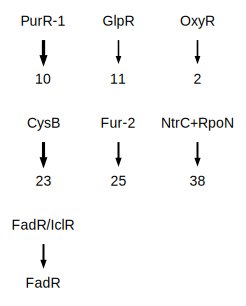

In [38]:
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.3,
                         ortho_file = '../example_data/example_bbh.csv')
dots

In the above plot, the top named iModulons are from *E. coli* and the bottom iModulons are from our target organism. Note that the two FadR iModulons are linked together. This `links` variable contains all pairs of iModulons that are linked together

In [39]:
links

[('GlpR', 11, 0.3067430727683906),
 ('OxyR', 2, 0.3244159538646938),
 ('PurR-1', 10, 0.6533523554798282),
 ('CysB', 23, 0.6176360657152684),
 ('NtrC+RpoN', 38, 0.3907067688896173),
 ('Fur-2', 25, 0.4045954149766546),
 ('FadR/IclR', 'FadR', 0.39750691518554104)]

In [40]:
for ecoli_mod,target_mod,dist in links:
    ica_data.imodulon_table.loc[target_mod,'ecoli_ortholog'] = ecoli_mod
ica_data.imodulon_table

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OxyR
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualize linked iModulons

In [41]:
from pymodulon.plotting import compare_gene_weights

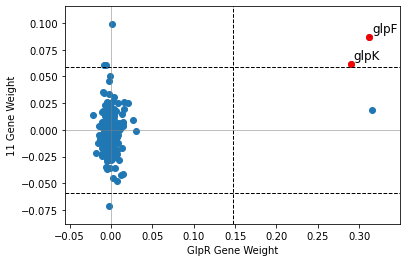

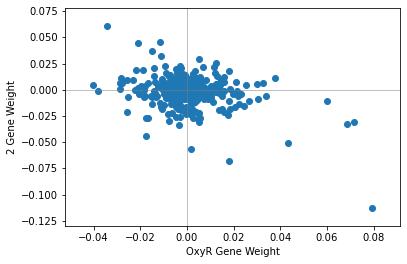

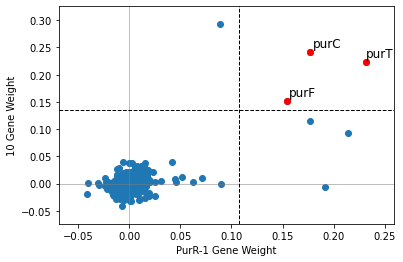

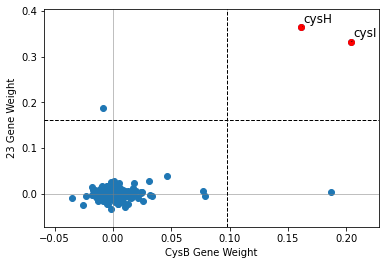

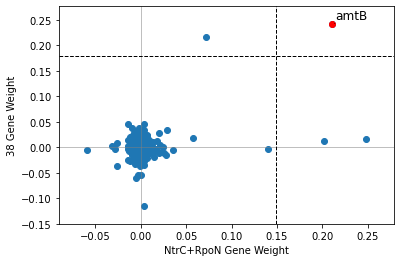

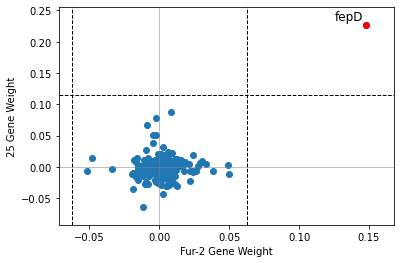

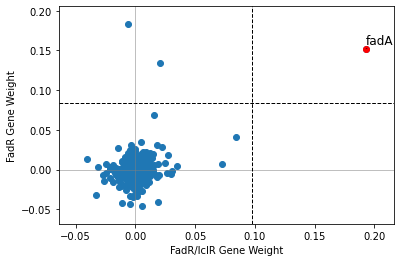

In [42]:
for ecoli_mod,saci_mod,_ in links:
    compare_gene_weights(ica_data = ecoli_data,imodulon1=ecoli_mod,
                         ica_data2 = ica_data,imodulon2=saci_mod,
                         ortho_file='../example_data/example_bbh.csv')

# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [43]:
save_to_json(ica_data,'../data/saci_ica_data.json')

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [44]:
ica_data.imodulon_table.to_csv('../data/iModulon_table.csv')

# Coming soon

1. Saving GO/KEGG enrichments to iModulon table
1. Plotting iModulon gene weights across organisms
1. Using iModulon activities to characterize iModulons
1. Finding motifs using MEME
1. Building iModulonDB web pages


{'ArnA;ArnB',
 'ArnR;ArnR1',
 'BarR',
 'FadR',
 'LrpC',
 'LysM',
 'MalR',
 'YtrA',
 'putatative_lrp_like'}